In [72]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
import os
import time
import pathlib

python_path = pathlib.Path('.').absolute().parent/'python'
os.sys.path.insert(1, str(python_path))

In [74]:
## This is demo for kuka reaching a with mpc and diff_qp
## Author : Avadesh Meduri
## Date : 25/02/2022

import time
import numpy as np
import pinocchio as pin
from robot_properties_kuka.config import IiwaConfig
from matplotlib import pyplot as plt

import meshcat
import meshcat.transformations as tf
import meshcat.geometry as g

from vocam.diff_pin_costs import DiffFrameTranslationCost, DiffFrameVelocityCost
from vocam.inverse_qp import IOC

import torch
from torch.autograd import Function
from torch.nn import functional as F

In [75]:
robot = IiwaConfig.buildRobotWrapper()
model, data = robot.model, robot.data
f_id = model.getFrameId("EE")

In [76]:
viz = pin.visualize.MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
viz.initViewer(open=False)
viz.loadViewerModel()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


In [68]:
dtc = DiffFrameTranslationCost.apply
dvc = DiffFrameVelocityCost.apply

def quadratic_loss(q_pred, x_des, nq, n_col):
    loss = 4.5e1*torch.linalg.norm(dtc(q_pred[-2*nq:], model, data, f_id) - x_des)
    loss += 1.5e0*torch.linalg.norm(dvc(q_pred[-2*nq:], torch.zeros(nq), model, data, f_id)) # asking for zero velocity
    loss += 1e-2*torch.linalg.norm(q_pred[-2*nq:-nq]) # joint regularization
    
    for i in range(n_col):    
        loss += 1e0*torch.linalg.norm(dtc(q_pred[(3*i)*nq: (3*i+2)*nq], model, data, f_id) - x_des)
        loss += 5e-1*torch.linalg.norm(dvc(q_pred[(3*i)*nq: (3*i+2)*nq], q_pred[(3*i+2)*nq:(3*i+3)*nq], model, data, f_id)) # asking for zero velocity
        loss += 1e-2*torch.linalg.norm(q_pred[(3*i+2)*nq: (3*i+3)*nq]) # control regularization
        loss += 2e-1*torch.linalg.norm(q_pred[(3*i+1)*nq: (3*i+2)*nq]) # velocity regularization
        loss += 3e-3*torch.linalg.norm(q_pred[(3*i)*nq: (3*i+1)*nq]) # joint regularization
        
        if i < n_col - 1:
            loss += 5e-2*torch.linalg.norm(torch.subtract(q_pred[(3*i+2)*nq: (3*i+3)*nq], \
                                                          q_pred[(3*i+5)*nq: (3*i+6)*nq]))

    return loss

In [69]:
nq = model.nq
nv = model.nv

n_col = 5
u_max = [2.5,2.5,2.5, 1.5, 1.5, 1.5, 1.0]

lr = 1e-1
eps = 80

# q_des = np.hstack(((np.pi/4)*(np.random.randint(0, 2, size = 5)), np.zeros(2)))

q_des_arr = np.array([[2.1789238e-02,  3.3214998e-01, -1.4518893e-04, -8.7141126e-01,
                          6.0329604e-01, -1.3965217e-03,  1.4794523e-04],
                      [1.3737, 0.9711, 1.6139, 1.2188, 1.5669, 0.1236, 0.2565]])
x_des_arr = torch.tensor([[0.6, 0.4, 0.5]]) #[0.6, 0.4, 1.0]

# q_init = np.hstack(((np.pi/8)*np.random.choice(list(range(-2, -1)) + list(range(1, 3)), size=(4)), np.zeros(3)))

x_init = np.zeros(2*nq)
x_init[0:nq] = q_des_arr[0] + 0.5*np.random.rand(nq)
# x_init[0:nq] = np.hstack(((np.pi/12)*(np.random.randint(3, 6, size = 5)), np.zeros(2)))
x_init[nq:] = 0.2*2*(np.random.rand(nv) - 0.5)



In [70]:
x_in = x_init
x_des = x_des_arr[np.random.randint(len(x_des_arr))]

viz.viewer["box"].set_object(g.Sphere(0.05), 
                         g.MeshLambertMaterial(
                             color=0xff22dd,
                             reflectivity=0.8))
viz.viewer["box"].set_transform(tf.translation_matrix(x_des.detach().numpy()))

plt_ddq = []

for j in range(20):

    ioc = IOC(n_col, nq, u_max, 0.05, eps = 1.0, isvec=True)
    optimizer = torch.optim.Adam(ioc.parameters(), lr=lr)
    
    
    i = 0
    loss = 1000.
    old_loss = 10000.
    
    while loss > 0.03 and i < eps and abs(old_loss - loss) > 5e-5:
        x_pred = ioc(x_in) 

        old_loss = loss

        loss = quadratic_loss(x_pred, x_des, nq, n_col)
        print("Index :" + str(i) + " loss is : " + str(loss.detach().numpy()), end = '\r', flush = True)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1
        
    x_pred = ioc(x_in).detach().numpy()

    for i in range(n_col+1):
        q = x_pred[3*nq*i:3*nq*i + nq]
        dq = x_pred[3*nq*i + nq:3*nq*i + 2*nq]
        if i < n_col:
            ddq = x_pred[3*nq*i + 2*nq:3*nq*i + 3*nq]
            plt_ddq.append(ddq)
        pin.forwardKinematics(model, data, q, dq, np.zeros(nv))
        pin.updateFramePlacements(model, data)

        viz.display(q)
        time.sleep(0.1)
    
    x_in = torch.tensor(x_pred[-2*nq:])

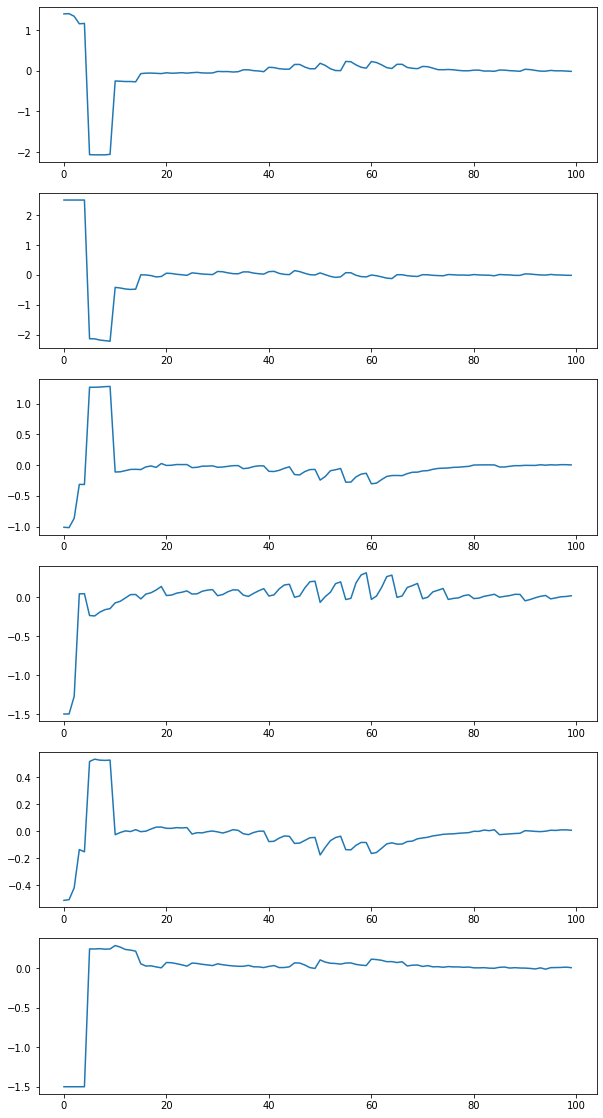

In [71]:
plt_ddq = np.array(plt_ddq)
fig, ax = plt.subplots(6, figsize = (10,20))
for i in range(6):
    ax[i].plot(plt_ddq[:,i])
plt.show()

In [ ]:
# x_train_loaded = torch.load("./data/x_train3.pt")
# y_train_loaded = torch.load("./data/y_train3.pt")

In [ ]:
# i = 50
# n_vars = 3*nq*n_col + 2*nq
# data = y_train_loaded[i]
# Q = torch.reshape(data[0:n_vars**2], (n_vars, n_vars))
# q = torch.nn.Parameter(data[n_vars**2:])
# print(q[-2*nq:-nq])
# print(q[-nq:])
# print(Q[-nq:,-nq:]@q[-nq:])